In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import h5py
import os
from math import pi

from analysis.config import birds, h5_path_dict, pickle_dir
from analysis.ExpData import ExpData
from analysis.utils import popln_overlap, get_fr

In [2]:
def get_site_distance(a, b):
    dist = min(
        abs(a - b), 16 - abs(a-b)
        ) % 16
    return dist

In [3]:
save_dir = pickle_dir/"reactivation_pairs_pchecks"
visit_types = [
    "cache", "retriev", "checkfull", "pcheckfull",
    "navfull", "checkempty", "pcheckempty", "navempty"
    ]
visit_types_titles = [
    "Cache", "Retrieval", "Check Full", "Put. Check Full",
    "Nav. Full", "Check Empty", "Put. Check Empty", "Nav. Empty"
    ]
cache, retriev, checkfull, pcheckfull, navfull, checkempty, pcheckempty, navempty = (0, 1, 2, 3, 4, 5, 6, 7)

## Make reactivation distribution table

In [4]:
table = np.zeros((9, 8, 8))

In [5]:
normalize = False
norm_dist = 8

In [8]:
for i, type_i in enumerate(visit_types):
    for j, type_j in enumerate(visit_types):
        if j < i: continue
        pk_file_ij = save_dir / f"{type_i}_{type_j}.p"
        pk_file_ji = save_dir / f"{type_j}_{type_i}.p"
        if os.path.isfile(pk_file_ij):
            pk_file = pk_file_ij
        elif os.path.isfile(pk_file_ji):
            pk_file = pk_file_ji
        else:
            continue
        with open(pk_file, "rb") as f:
            distance_matrix = np.array(pickle.load(f))
        vals_by_sitedist = [[] for _ in range(9)]
        for ii in range(distance_matrix.shape[0]):
            for jj in range(distance_matrix.shape[1]):
                mat_ij = np.array(distance_matrix[ii,jj])
                nonnan_vals = mat_ij[np.logical_not(np.isnan(mat_ij))].tolist()
                dist = get_site_distance(ii,jj)
                vals_by_sitedist[dist].extend(nonnan_vals)
        if normalize:
            norm_array = np.array(vals_by_sitedist[norm_dist])
            constant_divisor = np.sum(norm_array > 0.5)/norm_array.size
        else:
            constant_divisor = 1
        for dist in np.arange(9):
            all_vals = np.array(vals_by_sitedist[dist])
            val = np.sum(all_vals > 0.5)/all_vals.size
            table[dist][i][j] = val/constant_divisor
            table[dist][j][i] = val/constant_divisor

/home/chingf/anaconda3/envs/analysis-env/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in long_scalars


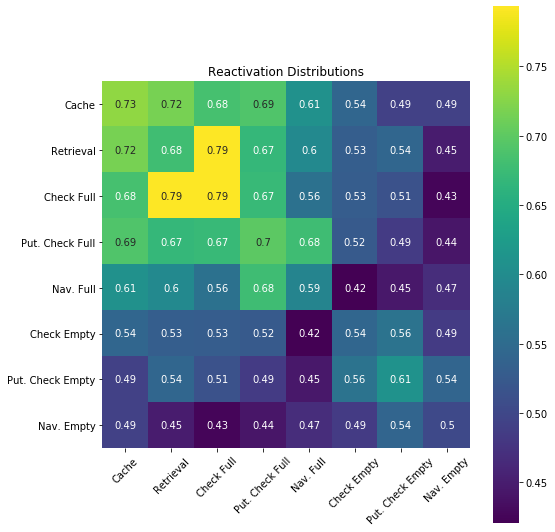

In [9]:
plt.figure(figsize=(8,8))
sns.heatmap(
    table[0], annot=True, cmap="viridis", square="True"
    )
plt.title("Reactivation Distributions")
plt.xticks(np.arange(8)+0.5, visit_types_titles, rotation=45)
plt.yticks(np.arange(8)+0.5, visit_types_titles, rotation=0)
plt.tight_layout()
plt.savefig("reactivation_table.png", dpi=200)
plt.show()

## Reactivation by Distance

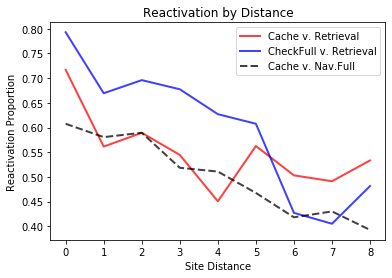

In [101]:
plt.figure()
plt.plot(
    table[:, cache, retrieval].T, "r-",
    label="Cache v. Retrieval", linewidth=2, alpha=0.75
    )
plt.plot(
    table[:, checkfull, retrieval].T, "b-",
    label="CheckFull v. Retrieval", linewidth=2, alpha=0.75
    )
plt.plot(
    table[:, cache, navfull].T, "k--",
    label="Cache v. Nav.Full", linewidth=2, alpha=0.75
    )
# plt.plot(
#     table[:, navfull, navfull].T, "k",
#     label="Nav.Full v. Nav. Full", linewidth=2, alpha=0.75
#     )
plt.title("Reactivation by Distance")
plt.xlabel("Site Distance")
plt.ylabel("Reactivation Proportion")
plt.legend()
plt.show()

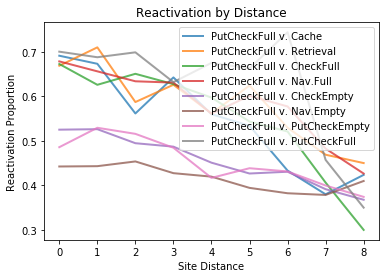

In [102]:
plt.figure()
plt.plot(
    table[:, pcheckfull, cache].T,
    label="PutCheckFull v. Cache", linewidth=2, alpha=0.75
    )
plt.plot(
    table[:, pcheckfull, retrieval].T,
    label="PutCheckFull v. Retrieval", linewidth=2, alpha=0.75
    )
plt.plot(
    table[:, pcheckfull, checkfull].T,
    label="PutCheckFull v. CheckFull", linewidth=2, alpha=0.75
    )
plt.plot(
    table[:, pcheckfull, navfull].T,
    label="PutCheckFull v. Nav.Full", linewidth=2, alpha=0.75
    )
plt.plot(
    table[:, pcheckfull, checkempty].T,
    label="PutCheckFull v. CheckEmpty", linewidth=2, alpha=0.75
    )
plt.plot(
    table[:, pcheckfull, navempty].T,
    label="PutCheckFull v. Nav.Empty", linewidth=2, alpha=0.75
    )
plt.plot(
    table[:, pcheckfull, pcheckempty].T,
    label="PutCheckFull v. PutCheckEmpty", linewidth=2, alpha=0.75
    )
plt.plot(
    table[:, pcheckfull, pcheckfull].T,
    label="PutCheckFull v. PutCheckFull", linewidth=2, alpha=0.75
    )
plt.title("Reactivation by Distance")
plt.xlabel("Site Distance")
plt.ylabel("Reactivation Proportion")
plt.legend()
plt.show()

In [96]:
for i, type_i in enumerate(visit_types):
    for j, type_j in enumerate(visit_types):
        if j >= i: continue
        for _i, _type_i in enumerate(visit_types):
            for _j, _type_j in enumerate(visit_types):
                if _j >= _i: continue
                if _i == i and _j == j: continue
                if np.sum(table[:,i,j] == table[:, _i, _j]) == 9:
                    print(f"{type_i}-{type_j} is identical to {_type_i}-{_type_j}")

checkempty-pcheckfull is identical to pcheckempty-checkfull
pcheckempty-checkfull is identical to checkempty-pcheckfull
